In [1]:
 import numpy as np

# ReLu 函数反射传播

In [2]:
class Relu:
    def __init__(self):
        self.cache = None
        
    def forward(self, x):
        self.cache = (x <= 0)
        out = np.maximum(0, x)
        return out
    
    def backward(self, dout):
        dout[self.cache] = 0
        dx = dout
        return dx

In [3]:
x = np.array([[1.0, -0.5], [-2.0, 3.0]])
layer = Relu()

print(layer.forward(x))
print(layer.cache)
print(layer.backward(x))

[[1. 0.]
 [0. 3.]]
[[False  True]
 [ True False]]
[[1. 0.]
 [0. 3.]]


# Sigmoid 函数反射传播

In [4]:
class Sigmoid:
    def __init__(self):
        self.out = None
        
    def forward(self, x):
        out = 1 / (1 + np.exp(-x))
        self.out = out
        return out
    
    def backward(self, dout):
        y = self.out
        dx = dout * y * (1-y)
        return dx

In [7]:
x = np.array([[1.0, -0.5], [-2.0, 3.0]])
layer = Sigmoid()

print(layer.forward(x))
print(layer.backward(x))

[[0.73105858 0.37754067]
 [0.11920292 0.95257413]]
[[ 0.19661193 -0.11750186]
 [-0.20998717  0.13552998]]


# Affine Transformation  仿射映射反射传播

In [8]:
class Affine:
    def __init__(self, W, b):
        self.W = W
        self.b = b
        self.x = None
        self.dW = None
        self.db = None
        
    def forward(self, x):
        self.x = x
        out = np.dot(self.x, self.W) + self.b
        return out
    
    def backward(self, dout):
        dx = np.dot(dout, self.W.T)
        self.dW = np.dot(self.x.T, dout)
        self.db = np.sum(dout)
        return dx

In [10]:
x = np.array([1.0, -0.5])
W = np.array([[0, 0, 0], [10, 10, 10]])
b = np.array([1, 2, 3])
layer = Affine(W, b)
print(layer.forward(x))

[-4. -3. -2.]


# Softmax with Loss 反向传播

In [15]:
def softmax_function(x):
    return np.exp(x) / np.sum(np.exp(x))

def cross_entropy_err(y_hat, y):
    delta = 1e-4
    return -np.sum(y*np.log(y_hat + delta))

class SoftmaxWithLoss:
    def __init__(self):
        self.loss = None
        self.y_hat = None
        self.y = None
        
    def forward(self, x, y):
        self.y = y
        self.y_hat = softmax_function(x)
        self.loss = cross_entropy_err(self.y_hat, self.y)
        return self.loss
    
    def backward(self, dout=1):
        batch_size = self.y.shape[0]
        dx = (self.y_hat - self.y) / batch_size
        return dx

In [16]:
x = np.array([0.2, 0.5, 0.3])
y = np.array([0, 1, 0])
layer = SoftmaxWithLoss()

print(layer.forward(x, y))
print(layer.backward())

0.9395751386979506
[ 0.0964777  -0.20310206  0.10662435]


# 实例：使用Stochastic Gradient Descent 训练ANN

## Softmax Function

In [39]:
def softmax_function(x):
    if x.ndim == 2:
        x = x.T
        x = x - np.max(x, axis = 0)
        y = np.exp(x) / np.sum(np.exp(x), axis = 0)
        return y.T
    
    x = x - np.max(x)
    return np.exp(x) / np.sum(np.exp(x))

## Cross Entropy Error Function

In [40]:
def cross_entropy_err(y_hat, y):
    y = y.reshape(1, y.size)
    y_hat = y_hat.reshape(1, y_hat.size)
    batch_size = y_hat.shape[0]
    return -np.sum(y * np.log(y_hat)) / batch_size

## Softmax With Loss

In [30]:
class SoftmaxWithLoss:
    def __init__(self):
        self.loss = None
        self.y_hat = None
        self.y = None
        
    def forward(self, x, y):
        self.y = y
        self.y_hat = softmax_function(x)
        self.loss = cross_entropy_err(self.y_hat, self.y)
        return self.loss
    
    def backward(self, dout=1):
        batch_size = self.y.shape[0]
        dx = (self.y_hat - self.y) / batch_size
        return dx

## Affine Transformation 反向传播

In [41]:
class Affine:
    def __init__(self, W, b):
        self.W = W
        self.b = b
        self.x = None
        self.dW = None
        self.db = None
        
    def forward(self, x):
        self.x = x
        out = np.dot(self.x, self.W) + self.b
        return out
    
    def backward(self, dout):
        dx = np.dot(dout, self.W.T)
        self.dW = np.dot(self.x.T, dout)
        self.db = np.sum(dout)
        return dx

## 训练神经网络

In [31]:
import numpy as np
from collections import OrderedDict

In [42]:
class ANN:
    def __init__(self, input_size, hidden_size, output_size, weight_init_std = 0.01):
        self.params = {}
        self.params['W1'] = weight_init_std * np.random.randn(input_size, hidden_size)
        self.params['b1'] = np.zeros(hidden_size)
        self.params['W2'] = weight_init_std * np.random.randn(hidden_size, output_size)
        self.params['b2'] = np.zeros(output_size)
        
        self.layers = OrderedDict()
        self.layers['Affine1'] = Affine(self.params['W1'], self.params['b1'])
        self.layers['Sigmoid1'] = Sigmoid()
        self.layers['Affine2'] = Affine(self.params['W2'], self.params['b2'])
        
        self.lastLayer = SoftmaxWithLoss()
        
    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)
        return x
    
    def loss(self, x, y):
        y_hat = self.predict(x)
        return self.lastLayer.forward(y_hat, y)
    
    def gradient(self, x, y):
        #forward
        self.loss(x, y)
        
        #backward
        dout = 1
        dout = self.lastLayer.backward(dout)
        
        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)
            
        grads = {}
        grads['W1'], grads['b1'] = self.layers['Affine1'].dW, self.layers['Affine1'].db
        grads['W2'], grads['b2'] = self.layers['Affine2'].dW, self.layers['Affine2'].db
        
        return grads
    

## 读取iris 数据

In [43]:
from sklearn.datasets import load_iris
iris = load_iris()

y = np.zeros((len(iris.target), 3))
for idx, val in enumerate(iris.target):
    y[idx, val] = 1


## 训练神经网络

In [44]:
import random

epochs = 10000
lr = 0.01
batch_size = 10
net = ANN(input_size = 4, hidden_size = 5, output_size = 3)

train_loss = []
for i in range(epochs):
    idx = np.random.choice(iris.data.shape[0], batch_size)
    x_batch = iris.data[idx]
    y_batch = y[idx]
    grad = net.gradient(x_batch, y_batch)
    for key in ('W1', 'b1', 'W2', 'b2'):
        net.params[key] -= lr * grad[key]
        
    loss = net.loss(x_batch, y_batch)
    train_loss.append(loss)

## 绘制损失图

Populating the interactive namespace from numpy and matplotlib


Text(0.5, 1.0, 'Training Loss')

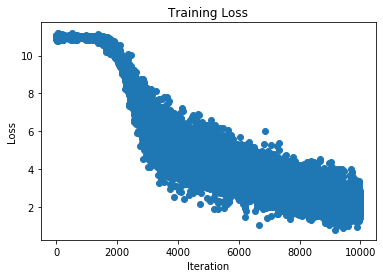

In [45]:
%pylab inline
import matplotlib.pyplot as plt

plt.scatter(range(0, 10000), train_loss)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training Loss')

## 验证模型准确率

In [46]:
from sklearn.metrics import accuracy_score, confusion_matrix

x = iris.data
predicted = np.argmax(net.predict(x), axis = 1)

# accuracy
sum(predicted == iris.target) / len(iris.target)

# accuracy
accuracy_score(iris.target, predicted)

# confusion matrix
confusion_matrix(iris.target, predicted)

array([[50,  0,  0],
       [ 0, 46,  4],
       [ 0,  0, 50]])